<a href="https://colab.research.google.com/github/abigailalbuquerque/SimpleAndComparableSleepStageScoring/blob/collab_code/EEG_spectrogram_classifier_Sc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, cohen_kappa_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import math

In [ ]:
# Clear the direcotry
!rm -rf 'training_set_00_17_Sc'
!rm -rf 'testing_set_18_19_Sc'

In [ ]:
# Unzip imported training and testing dataset 
!unzip /content/drive/MyDrive/Colab_Data/training_set_00_17_Sc.zip
!unzip /content/drive/MyDrive/Colab_Data/testing_set_18_19_Sc.zip

In [ ]:
# Load X_train and Y_train

subject_id_list = np.array(["SC4001E0", "SC4002E0", "SC4011E0", "SC4012E0", "SC4021E0", "SC4022E0", 
                            "SC4031E0", "SC4032E0", "SC4041E0", "SC4042E0", "SC4051E0", "SC4052E0", 
                            "SC4061E0", "SC4062E0", "SC4071E0", "SC4072E0", "SC4081E0", "SC4082E0", 
                            "SC4091E0", "SC4092E0", "SC4101E0", "SC4102E0", "SC4111E0", "SC4112E0", 
                            "SC4121E0", "SC4122E0", "SC4131E0", 
                            "SC4141E0", "SC4142E0", "SC4151E0", "SC4152E0", "SC4161E0", "SC4162E0", 
                            "SC4171E0", "SC4172E0"])
X_train_raw = np.empty((0, 138, 28))
Y_train_raw = np.empty((0))

for subject_id in subject_id_list:
  print('\r', f"loading...: {subject_id}", end='')
  X_file_name = 'training_set_00_17_Sc/' + 'X_' + subject_id + '.mat'
  Y_file_name = 'training_set_00_17_Sc/' + 'Y_' + subject_id + '.mat'

  # extract data from X
  mat = loadmat(X_file_name)
  mat_3d = mat['Sc_ds']
  numpy_3d = np.array(mat_3d)
  numpy_3d_reshape = numpy_3d.transpose((2,1,0))
  X_train_raw = np.concatenate((X_train_raw, numpy_3d_reshape), axis=0)

  # extract data from Y
  Y_true = loadmat(Y_file_name)
  Y_train = Y_true['y_true_list']
  Y_train = Y_train.flatten()
  Y_train_raw = np.append(Y_train_raw, Y_train)

  # print the shape to check size

print('  Done')
print(X_train_raw.shape)
print(Y_train_raw.shape)

# Load X_test and Y_test--------------------------------------------------------

subject_id_list = np.array(["SC4181E0", "SC4182E0", "SC4191E0", "SC4192E0"])
X_test_raw = np.empty((0, 138, 28))
Y_test_raw = np.empty((0))

for subject_id in subject_id_list:
  print('\r', f"loading...: {subject_id}", end='')
  X_file_name = 'testing_set_18_19_Sc/' + 'X_' + subject_id + '.mat'
  Y_file_name = 'testing_set_18_19_Sc/' + 'Y_' + subject_id + '.mat'

  # extract data from X
  mat = loadmat(X_file_name)
  mat_3d = mat['Sc_ds']
  numpy_3d = np.array(mat_3d)
  numpy_3d_reshape = numpy_3d.transpose((2,1,0))
  X_test_raw = np.concatenate((X_test_raw, numpy_3d_reshape), axis=0)

  # extract data from Y
  Y_true = loadmat(Y_file_name)
  Y_test = Y_true['y_true_list']
  Y_test = Y_test.flatten()
  Y_test_raw = np.append(Y_test_raw, Y_test)

  # print the shape to check size

print('  Done')
print(X_test_raw.shape)
print(Y_test_raw.shape)

# Expand the raw value e^8------------------------------------------------------ 

X_train_raw = X_train_raw*(10**8)
X_test_raw = X_test_raw*(10**8)

 loading...: SC4172E0  Done
(39527, 138, 28)
(39527,)
 loading...: SC4192E0  Done
(4693, 138, 28)
(4693,)


In [ ]:
# Oversampling

def class_info(Y_train, Y_test):
  # Get the number of different classes from true and pred
  print('         Train  Test')
  unique, true_counts = np.unique(Y_train, return_counts=True)
  unique, pred_counts = np.unique(Y_test, return_counts=True)
  print(np.asarray((['Wake', 'N1', 'N2', 'N3', 'REM'], true_counts, pred_counts)).T)

# get the class_info before oversampling
class_info(Y_train_raw, Y_test_raw)

# input the raw X and Y, return the oversampled X and Y
def oversampling(X_raw, Y_raw):
  X = X_raw
  y = Y_raw

  y = y.astype(int)
  max_size = np.max(np.bincount(y))
  size_diffs = [max_size - np.sum(y == i) for i in range(5)]

  for i in range(5):
    if size_diffs[i] > 0:
        idxs = np.where(y == i)[0]
        n_dup = size_diffs[i]
        idxs_to_dup = np.random.choice(idxs, size=n_dup, replace=True)
        X = np.concatenate((X, X[idxs_to_dup]), axis=0)
        y = np.concatenate((y, np.full(n_dup, i)), axis=0)

  return X, y

X_oversampled_train, Y_oversampled_train = oversampling(X_train_raw, Y_train_raw)

# get the class_info after oversampling
class_info(Y_oversampled_train, Y_test_raw)

         Train  Test
[['Wake' '9348' '849']
 ['N1' '2434' '370']
 ['N2' '15854' '1945']
 ['N3' '5026' '677']
 ['REM' '6865' '852']]
         Train  Test
[['Wake' '15854' '849']
 ['N1' '15854' '370']
 ['N2' '15854' '1945']
 ['N3' '15854' '677']
 ['REM' '15854' '852']]


In [ ]:
# Prepare the train valid test ds

x_train, x_valid, y_train, y_valid = train_test_split(X_oversampled_train, Y_oversampled_train, test_size=0.2, shuffle=True)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_raw, Y_test_raw)).batch(32)

In [ ]:
# Visualize the data

X = X_oversampled_train
Y = Y_oversampled_train

print('Total size:', Y.shape)

epoch_idx = 50000    # note that python starts with 0 but MATLAB starts with 1
epoch_num = 5
for i in range(epoch_num):   # slice each 30s epoch into 5 sub_epochs
  ax = plt.subplot(1, epoch_num, i + 1)
  # plt.figure(figsize=(2, 11))
  plt.imshow(X[epoch_idx+i,:,:], cmap='turbo')
  plt.title(int(Y[epoch_idx+i]))
  plt.gca().invert_yaxis()    # flip the y-axis
  plt.axis("off")

plt.figure(0)
plt.figure(figsize=(6,1))
plt.ylim([0, 5])
plt.plot(Y[epoch_idx:epoch_idx+epoch_num-1])


In [ ]:
# Create CNN model

IMAGE_HEIGHT = 138
IMAGE_WIDTH = 28
N_CHANNELS = 1
N_CLASSES = 5

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten()) # reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor 
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)


# Train model for 10 epochs, capture the history
history = model.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10
1982/1982 [==============================] - 26s 8ms/step - loss: 1.0420 - accuracy: 0.6183 - val_loss: 0.7480 - val_accuracy: 0.7077
Epoch 2/10
1982/1982 [==============================] - 14s 7ms/step - loss: 0.7856 - accuracy: 0.6904 - val_loss: 0.7002 - val_accuracy: 0.7251
Epoch 3/10
1982/1982 [==============================] - 14s 7ms/step - loss: 0.7435 - accuracy: 0.7091 - val_loss: 0.6782 - val_accuracy: 0.7340
Epoch 4/10
1982/1982 [==============================] - 14s 7ms/step - loss: 0.7259 - accuracy: 0.7172 - val_loss: 0.6623 - val_accuracy: 0.7427
Epoch 5/10
1982/1982 [==============================] - 14s 7ms/step - loss: 0.7154 - accuracy: 0.7216 - val_loss: 0.6694 - val_accuracy: 0.7400
Epoch 6/10
1982/1982 [==============================] - 14s 7ms/step - loss: 0.7154 - accuracy: 0.7229 - val_loss: 0.6597 - val_accuracy: 0.7461
Epoch 7/10
1982/1982 [==============================] - 14s 7ms/step - loss: 0.7181 - accuracy: 0.7253 - val_loss: 0.6549 - val_ac

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 138, 28, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 138, 28, 32)       4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 69, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 67, 12, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 65, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 5, 64)        0         
 2D)                                                    

147/147 [==============================] - 1s 4ms/step
Overall Accuracy:  0.751
Precision per-class: [0.696 0.269 0.944 0.806 0.655]
Recall per-class: [0.736 0.319 0.793 0.866 0.765]
F1 per-class: [0.716 0.292 0.862 0.835 0.706]
F1(weighted): 0.758
         True  Pred
[['Wake' '849' '898']
 ['N1' '370' '438']
 ['N2' '1945' '1634']
 ['N3' '677' '727']
 ['REM' '852' '996']]


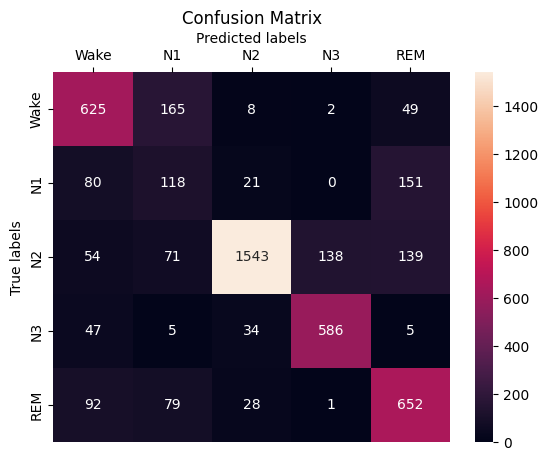

In [ ]:
# Evaluate the model with test_set
evaluation_set = test_ds

predictions = model.predict(evaluation_set)
label_pred = np.array([])
for sub in predictions:
  max_idx = np.argmax(sub)
  label_pred = np.append(label_pred, max_idx)
test_label = np.concatenate([y for x, y in evaluation_set], axis=0)

# Get confusion matrix and plot out
cm = confusion_matrix(test_label, label_pred)

# Get acc, precision, recall, and f1
acc = accuracy_score(test_label, label_pred)
print('Overall Accuracy: ', acc.round(3))
precision = precision_score(test_label, label_pred, average=None)
print('Precision per-class:', precision.round(3))
recall = recall_score(test_label, label_pred, average=None)
print('Recall per-class:', recall.round(3))
f1score = f1_score(test_label, label_pred, average=None)
print('F1 per-class:', f1score.round(3))
f1weighted = f1_score(test_label, label_pred, average='weighted')   # conpute the f1 for each label and returns the average considering the proportion of each label
print('F1(weighted):', f1weighted.round(3))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt 
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Wake', 'N1', 'N2', 'N3', 'REM']); ax.yaxis.set_ticklabels(['Wake', 'N1', 'N2', 'N3', 'REM']);
# move labels to the top
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_label_position('top') 

# Get the number of different classes from true and pred
print('         True  Pred')
unique, true_counts = np.unique(test_label, return_counts=True)
unique, pred_counts = np.unique(label_pred, return_counts=True)
print(np.asarray((['Wake', 'N1', 'N2', 'N3', 'REM'], true_counts, pred_counts)).T)

